In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline




In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Load Data
df = pd.read_csv('/content/drive/MyDrive/bitcointweets.csv.zip', header=None)
pd.set_option('display.max_colwidth', -1)
df = df[[1,7]]
df.columns = ['tweet','label']
df.head()

,tweet,label
0,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I had to tweak the nose of this Bitcoin enemy. He says such foolish things. Here's the link: htt…",['neutral']
1,@lopp @_Kevin_Pham @psycho_sage @naval But @ProfFaustus (dum b a ss) said you know nothing about #Bitcoin ... 😂😂😂 https://t.co/SBAMFQ2Yiy,['neutral']
2,RT @tippereconomy: Another use case for #blockchain and #Tipper. The #TipperEconomy can unseat Facebook and change everything! ICO Live No…,['positive']
3,free coins https://t.co/DiuoePJdap,['positive']
4,RT @payvxofficial: WE are happy to announce that PayVX Presale Phase 1 is now LIVE!\n\nSign up --&gt;&gt; https://t.co/dhprzsSxek\nCurrencies accept…,['positive']


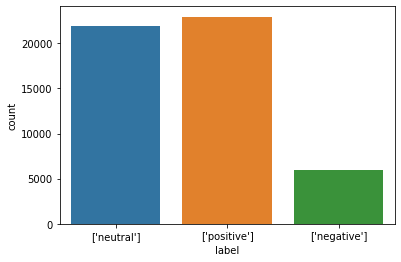

In [ ]:
# inspect sentiment
sns.countplot(df['label'])

In [ ]:
# text length
df['text_length'] = df['tweet'].apply(len)
df[['label','text_length','tweet']].head()

,label,text_length,tweet
0,['neutral'],140,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I had to tweak the nose of this Bitcoin enemy. He says such foolish things. Here's the link: htt…"
1,['neutral'],137,@lopp @_Kevin_Pham @psycho_sage @naval But @ProfFaustus (dum b a ss) said you know nothing about #Bitcoin ... 😂😂😂 https://t.co/SBAMFQ2Yiy
2,['positive'],140,RT @tippereconomy: Another use case for #blockchain and #Tipper. The #TipperEconomy can unseat Facebook and change everything! ICO Live No…
3,['positive'],34,free coins https://t.co/DiuoePJdap
4,['positive'],146,RT @payvxofficial: WE are happy to announce that PayVX Presale Phase 1 is now LIVE!\n\nSign up --&gt;&gt; https://t.co/dhprzsSxek\nCurrencies accept…


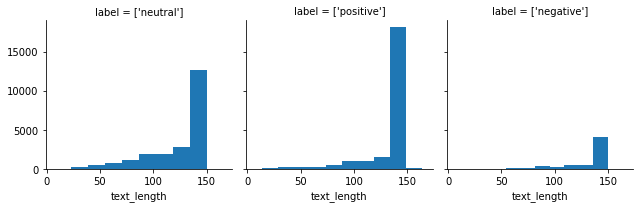

In [ ]:
g = sns.FacetGrid(df,col='label')
g.map(plt.hist,'text_length')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


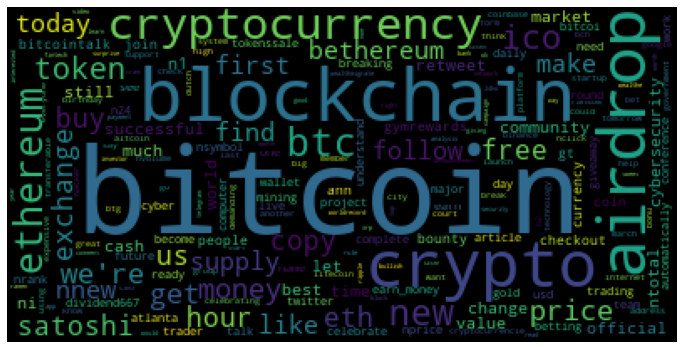

In [ ]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import nltk
nltk.download('stopwords')


def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s
df['clean_tweet'] = df['tweet'].apply(clean_text)

text = df['clean_tweet'].to_string().lower()    
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [ ]:
# Encode Categorical Variable
X = df['clean_tweet']
y = pd.get_dummies(df['label']).values
num_classes = df['label'].nunique()

In [ ]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [ ]:
# Split Train Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40687,) (10172,) (40687, 3) (10172, 3)


In [ ]:
# Tokenize Text
from keras.preprocessing.text import Tokenizer
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

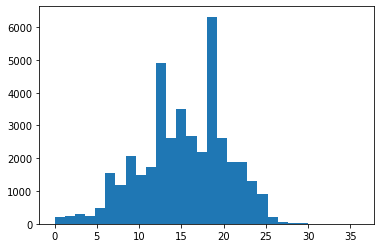

In [ ]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()

In [ ]:
from keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(40687, 30) (10172, 30)


In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 3

In [ ]:
# This deep learning model will have 2 CNN layers, 1 LSTM layer, and final dense layer for classification

In [ ]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

In [ ]:
def model_evaluate(): 
    # predict class with test set
    y_pred_test =  np.argmax(model.predict(X_test), axis=1)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

In [ ]:
# train the model
max_features = 20000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

Accuracy:	97.6%


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1197
           1       0.98      0.98      0.98      4388
           2       0.98      0.98      0.98      4587

    accuracy                           0.98     10172
   macro avg       0.97      0.97      0.97     10172
weighted avg       0.98      0.98      0.98     10172



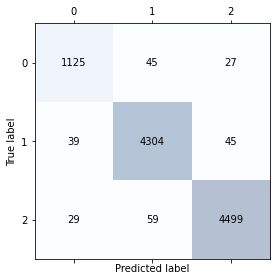

In [ ]:
# evaluate model with test set
model_evaluate()